In [1]:
import xarray as xr
import numpy as np
import om4labs.om4common as om4
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt


# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [6]:
path = '/work/Katherine.Turner/tempest-extremes/odiv-251/wind_blobs/'
ds = xr.open_mfdataset(f"{path}SH_winds_3day_*.nc", use_cftime=True)

path_temp = '/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear151/gfdl.ncrc5-intel22-prod-openmp/pp/atmos/ts/6hr/5yr/'

files = [path_temp + 'atmos.0151010100-0155123123.t_ref.nc', 
         path_temp + 'atmos.0161010100-0165123123.t_ref.nc', path_temp + 'atmos.0166010100-0170123123.t_ref.nc',
         path_temp + 'atmos.0171010100-0175123123.t_ref.nc', path_temp + 'atmos.0176010100-0180123123.t_ref.nc',
         path_temp + 'atmos.0181010100-0185123123.t_ref.nc', path_temp + 'atmos.0186010100-0190123123.t_ref.nc',
         path_temp + 'atmos.0191010100-0195123123.t_ref.nc', path_temp + 'atmos.0196010100-0200123123.t_ref.nc',
         path_temp + 'atmos.0201010100-0205123123.t_ref.nc', path_temp + 'atmos.0206010100-0210123123.t_ref.nc',
         path_temp + 'atmos.0211010100-0215123123.t_ref.nc', path_temp + 'atmos.0216010100-0220123123.t_ref.nc',
         path_temp + 'atmos.0221010100-0225123123.t_ref.nc', path_temp + 'atmos.0226010100-0230123123.t_ref.nc',
         path_temp + 'atmos.0231010100-0235123123.t_ref.nc', path_temp + 'atmos.0236010100-0240123123.t_ref.nc',
         path_temp + 'atmos.0241010100-0245123123.t_ref.nc',
        ]

ds_t = xr.open_mfdataset(files, use_cftime=True)

In [35]:
ds_t = xr.open_mfdataset('/work/Katherine.Turner/tempest-extremes/odiv-251/data/*.hf*.nc', use_cftime=True)

In [36]:
hf_turb = ds_t.hfsso + ds_t.hflso

In [37]:
ds_out = hf_turb.to_dataset(name='hf_turb').chunk({'lat':30, 'lon':24, 'time':-1})
ds_out.to_zarr('/xtmp/Katherine.Turner/work/model_zarrs/CM4_hf_turb')

In [38]:
del ds_out

In [15]:
idx = ds.object_id/ ds.object_id
idx_binary = idx.fillna(0).astype(int)

ds_out = idx.chunk({'lat':30, 'lon':24, 'time':-1}).to_dataset(name='windy_idx')
ds_out.to_zarr('/xtmp/Katherine.Turner/work/model_zarrs/CM4_windy_idx')

### b) Creating climatology of temperatures

In [17]:
time_array = np.concatenate((np.arange(5*365*4), np.arange(10*365*4, len(idx.time))))
time_array

array([     0,      1,      2, ..., 138697, 138698, 138699])

In [18]:
ds_idx = xr.open_zarr('/xtmp/Katherine.Turner/work/model_zarrs/CM4_windy_idx')
ds_tref = xr.open_zarr('/xtmp/Katherine.Turner/work/model_zarrs/CM4_t_ref')

In [21]:
time_6h = idx.time[time_array]
ds_out = ds_tref.interp(time=time_6h)

ds_out.to_zarr('/xtmp/Katherine.Turner/work/model_zarrs/CM4_t_ref_6hr')

In [40]:
ds = xr.open_zarr('/xtmp/Katherine.Turner/work/model_zarrs/CM4_hf_turb')
tclim = ds.hf_turb.groupby(ds.time.dt.dayofyear).mean()
tanom = ds.hf_turb.groupby(ds.time.dt.dayofyear) - tclim

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/xarray/core/indexing.py:1384: PerformanceWarning: Slicing with an out-of-order index is generating 95 times more chunks
  return self.array[key]


In [41]:
tanom = tanom.chunk({'time':-1})
tanom.to_dataset(name='hf_turb_anom').to_zarr('/xtmp/Katherine.Turner/work/model_zarrs/CM4_hf_turb_anom')

## Looking at the temperature anomalies underneath windy events

In [42]:
ds_idx = xr.open_zarr('/xtmp/Katherine.Turner/work/model_zarrs/CM4_windy_idx')
dt = xr.open_zarr('/xtmp/Katherine.Turner/work/model_zarrs/CM4_hf_turb_anom')

In [49]:
tanom_wind = (dt.hf_turb_anom * ds_idx.windy_idx).mean(dim='time').compute()

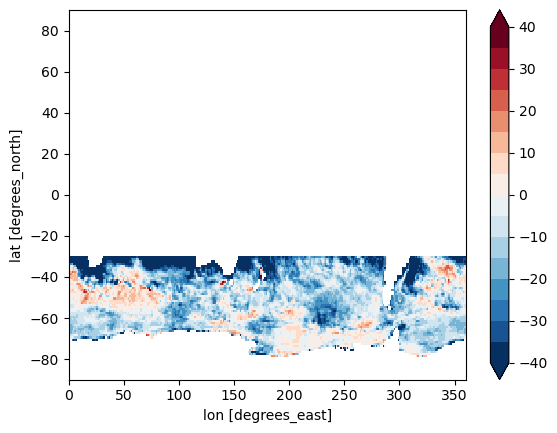

In [57]:
(dt.hf_turb_anom * ds_idx.windy_idx)[:365,:,:].mean(dim='time').plot(vmin=-40, vmax=40, 
                                                                     cmap=plt.get_cmap('RdBu_r',16))

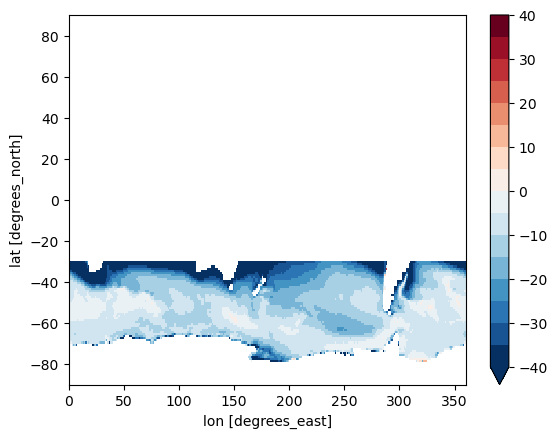

In [58]:
tanom_wind.plot(vmin=-40, vmax=40, 
                cmap=plt.get_cmap('RdBu_r',16))

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()},
                       figsize=(11,4))
axs=axs.flatten()


ds_hist.hist_5deg.plot(ax=axs[0],
                       transform=ccrs.PlateCarree(),
                       cbar_kwargs={'label': ''},
                      )
axs[0].set_title('Extratropical cyclone \n histogram')

wind_ann.plot(ax=axs[1],
              transform=ccrs.PlateCarree(),
              cbar_kwargs={'label': ''},
             )
axs[1].set_title('Mean windspeed')

(1/(4*365*95) * windy_days_ann).plot(ax=axs[2],
                                     transform=ccrs.PlateCarree(),
                                     cbar_kwargs={'label': ''},
                                    )
axs[2].set_title('Fraction of days with \n continual strong winds')

for i in range(3):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig('/home/Katherine.Turner/storminess_comp_annual.png', format='png', dpi=100)

## Interannual variability in storm center numbers

In [ ]:
year_counts_summer = xr.DataArray(
    data = [4396, 4249, 4211, 4280, 4388, 4311, 4315, 4298, 4511, 3994,
       4198, 4367, 4315, 4209, 4293, 4225, 4263, 4364, 4346, 4333, 4040,
       4369, 4306, 4541, 4520, 4028, 4378, 4166, 4415, 4319, 4563, 4427,
       4555, 4435, 4496, 4363, 4460, 4283, 4043, 4151, 4515, 4118, 4408,
       4420, 4349, 4667, 4153, 4353, 4482, 4145, 4150, 4678, 4479, 4351,
       4215, 4400, 4169, 4337, 4179, 4423, 4228, 3981, 4232, 4020, 4446,
       4406, 4123, 4527, 4635, 4146, 4397, 4126, 4333, 4127, 4176, 4225,
       4275, 4569, 4599, 4437, 3950, 4337, 4155, 4423, 4261, 4011, 4172,
       4218, 4434, 4539, 4380, 4258, 4516, 4518],
    dims = ['time'],
    coords=dict(
        time=djf_windy.time.data
    )
)
year_counts_summer

In [ ]:
wind_SO = (da * djf_windy).sum(dim=['lat', 'lon'])

In [ ]:
((wind_SO - wind_SO.mean())/wind_SO.std()).plot()
((year_counts_summer - year_counts_summer.mean())/year_counts_summer.std()).plot()

In [ ]:
plt.scatter((wind_SO - wind_SO.mean())/wind_SO.std(), 
            (year_counts_summer - year_counts_summer.mean())/year_counts_summer.std())

In [ ]:
np.corrcoef(wind_SO, year_counts_summer)